## CNN Training and Classification with Chainer

We'll use the data set 'CIFAR-10' (in cPickle format).  
Download 'CIFAR-10 python version' from http://www.cs.toronto.edu/~kriz/cifar.html, extract the 'cifar-10-batches-py' directory, and then set the correct path to the directory.

In [1]:
path_to_cifar10 = 'cifar-10-batches-py/'

Take the training data out using key 'data' and 'labels'. For training with chainer,  
- data must be a numpy array with type float32
- if image, its axes in order (key, channels, height, width)
- labels must be a numpy array with type int32  

In [2]:
import six.moves.cPickle as pickle

def unpickle(file):
    f = open(file, 'rb')
    data = pickle.load(f)
    f.close()
    return data

In [3]:
import numpy as np
np.random.seed(0)

train_data = []
train_labels = []

for i in range(1,6):
    batch = unpickle(path_to_cifar10 + 'data_batch_{0:d}'.format(i))
    train_data.extend(batch['data'])
    train_labels.extend(batch['labels'])

train_labels = np.array(train_labels).astype(np.int32)
train_data = np.array(train_data).astype(np.float32)
train_data = train_data.reshape(train_data.shape[0],3,32,32)

Set the validation data in the same format as the traing data.

In [4]:
batch = unpickle(path_to_cifar10 + 'test_batch')
test_labels = np.array(batch['labels']).astype(np.int32)
test_data = np.array(batch['data']).astype(np.float32)
test_data = test_data.reshape(test_data.shape[0],3,32,32)

Get the mean value of each color channel and subtract them from the data.

In [5]:
mean = [0,0,0]
for datum in train_data:
    for ch in range(3):
        mean[ch] += datum[ch].sum()/datum[ch].size
mean = np.array(mean)
mean /= train_data.shape[0]
print mean
train_data -= mean[np.newaxis, :, np.newaxis, np.newaxis]
train_data /= 255
test_data -= mean[np.newaxis, :, np.newaxis, np.newaxis]
test_data /= 255

[ 125.30691805  122.95039414  113.86538318]


The labels (0 to 9) correspond to 'label names' array in this meta batch.

In [6]:
batch = unpickle(path_to_cifar10 + 'batches.meta')
label_names = batch['label_names']
print label_names

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's take a look at some data in CIFAR-10.

In [7]:
def imdeprocess(datum):
    im = datum + mean[:, np.newaxis, np.newaxis]/255
    im = im.transpose((1,2,0))
    return im

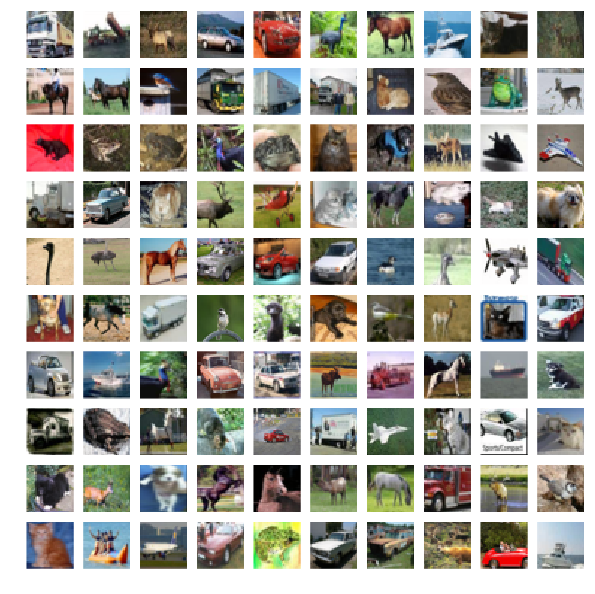

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(1,101):
    plt.subplot(10,10,i)
    plt.axis('off')
    plt.imshow(imdeprocess(train_data[i]), interpolation='none')

CIFAR-10 includes 50000 images for training and 10000 for test.

In [9]:
N = train_labels.shape[0]
N_test = test_labels.shape[0]
print 'data for training: ' + str(N)
print 'data for test: ' + str(N_test)

data for training: 50000
data for test: 10000


Import chainer and the dependencies.

In [10]:
import six
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

If you use a gpu, set the gpu device value here.

In [11]:
gpu = 0 # gpu device ID (cpu if this negative)
xp = cuda.cupy if gpu >= 0 else np

Describe the neural net architecture you want to train.

In [12]:
class CNN(chainer.Chain):
    
    def __init__(self):
        super(CNN, self).__init__(
            conv1=L.Convolution2D(3, 64, ksize=3, pad=1),
            conv2=L.Convolution2D(64, 64, ksize=3, pad=1),
            conv3=L.Convolution2D(64, 128, ksize=3, pad=1),
            conv4=L.Convolution2D(128, 128, ksize=3, pad=1),
            fc5=L.Linear(8192, 1024),
            fc6=L.Linear(1024, 10),
        )
    
    # train
    def __call__(self, x, t):
        self.forward(x, train=True)
        self.loss = F.softmax_cross_entropy(self.y, t)
        self.accuracy = F.accuracy(self.y, t)
        return self.loss
    
    # test
    def test(self, x, t):
        self.forward(x, train=False)
        self.loss = F.softmax_cross_entropy(self.y, t)
        self.accuracy = F.accuracy(self.y, t)
        return self.loss
    
    def forward(self, x, train=False):
        self.x = x
        self.h1 = F.relu(self.conv1(self.x))
        self.h2 = F.max_pooling_2d(F.relu(self.conv2(self.h1)), ksize=2, stride=2)
        self.h3 = F.relu(self.conv3(self.h2))
        self.h4 = F.max_pooling_2d(F.relu(self.conv4(self.h3)), ksize=2, stride=2)
        self.h5 = F.dropout(F.relu(self.fc5(self.h4)), train=train)
        self.y = self.fc6(self.h5)
        return self.y

Set the optimizer. (MomentumSGD, AdaDelta, AdaGrad, Adam, ...)

In [13]:
model = CNN()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
if gpu >= 0:
    cuda.get_device(gpu).use()
    model.to_gpu()
batchsize = 100

Define the 'test_net' function to get the accuracy of the validation data.

In [14]:
import sys
import progressbar as prg
losses, test_its, test_losses, test_accs = ([] for i in range(4))
def test(x, y):
    sum_accuracy = 0
    sum_loss = 0
    with prg.ProgressBar(max_value=len(y)) as bar:
        for i in six.moves.range(0, len(y), batchsize):
            x_batch = chainer.Variable(
                xp.asarray(x[i:i + batchsize]), volatile='on')
            t_batch = chainer.Variable(
                xp.asarray(y[i:i + batchsize]), volatile='on')
            model.test(x_batch, t_batch)
            sum_loss += float(model.loss.data) * len(t_batch)
            sum_accuracy += float(model.accuracy.data) * len(t_batch)
            bar.update(i)
    sys.stderr.flush()
    test_its.append(len(losses))
    loss = sum_loss/len(y)
    accuracy = sum_accuracy /len(y)
    test_losses.append(loss)
    test_accs.append(accuracy)
    return loss, accuracy

In [15]:
loss, acc = test(test_data, test_labels)
print ('test: loss={}, accuracy={}'.format(str(loss), str(acc)))

100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.38


test: loss=2.30514733076, accuracy=0.10079999987


We're going to train the model by using the training data 'n_epoch' times.

In [16]:
n_epoch = 10

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    
    # training
    perm = np.random.permutation(N)
    with prg.ProgressBar(max_value=N) as bar:
        for i in six.moves.range(0, N, batchsize):
            x = chainer.Variable(
                xp.asarray(train_data[perm[i:i + batchsize]]),  volatile='off')
            t = chainer.Variable(
                xp.asarray(train_labels[perm[i:i + batchsize]]),  volatile='off')
            optimizer.update(model, x, t)
            losses.append(float(model.loss.data))
            sys.stderr.write(' Loss: {}'.format(str(float(model.loss.data))))
            bar.update(i)
    sys.stderr.flush()
    
    # evaluate
    loss, acc = test(test_data, test_labels)
    print('train: batch={}, loss={}'.format(
        str(i/batchsize+1), str(float(model.loss.data))))
    print ('test: loss={}, accuracy={}'.format(str(loss), str(acc)))
    sys.stdout.flush()
    
    # save model
    model_filename = 'cnn-cifar10-epoch{0:d}.chainermodel'.format(epoch)
    serializers.save_hdf5(model_filename, model)

100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.39
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 1.00


('epoch', 1)
train: batch=500, loss=1.10399186611
test: loss=1.00630943537, accuracy=0.653800001144


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.48
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 1.00


('epoch', 2)
train: batch=500, loss=0.857162177563
test: loss=0.779913466573, accuracy=0.726100000739


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.29
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 0.99


('epoch', 3)
train: batch=500, loss=0.701265096664
test: loss=0.685440801978, accuracy=0.760999994278


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.72
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.02


('epoch', 4)
train: batch=500, loss=0.744906723499
test: loss=0.699822220504, accuracy=0.765599999428


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.38
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.02


('epoch', 5)
train: batch=500, loss=0.653534531593
test: loss=0.656668325067, accuracy=0.779199997783


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.37
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.01


('epoch', 6)
train: batch=500, loss=0.605970025063
test: loss=0.65676571399, accuracy=0.78869999826


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.29
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 1.00


('epoch', 7)
train: batch=500, loss=0.623643040657
test: loss=0.754974782467, accuracy=0.788099995255


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.33
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:01 Time: 1.01


('epoch', 8)
train: batch=500, loss=0.888608694077
test: loss=0.768255901039, accuracy=0.786100000739


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.44
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 1.00


('epoch', 9)
train: batch=500, loss=0.840965569019
test: loss=0.898935815692, accuracy=0.780099999309


100% (50000 of 50000) |######################| Elapsed Time: 0:00:18 Time: 18.43
100% (10000 of 10000) |#######################| Elapsed Time: 0:00:00 Time: 1.00


('epoch', 10)
train: batch=500, loss=1.13829910755
test: loss=0.923391751647, accuracy=0.787999996543


Plot the losses and the accuracies.

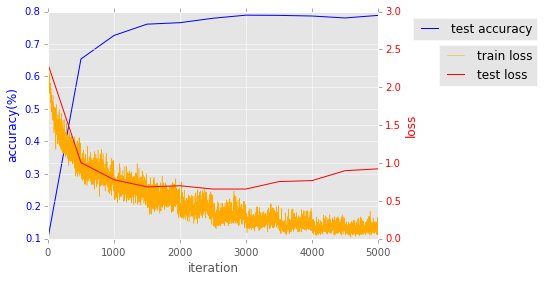

In [17]:
fig, ax1 = plt.subplots()
ax1.plot(test_its, test_accs, 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy(%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.legend(['test accuracy'], bbox_to_anchor=(1.5,1))
ax2 = ax1.twinx()
ax2.plot(range(len(losses)), losses, ls='-', lw=0.5, color='#ffaa00')
ax2.plot(test_its, test_losses, 'r-')
ax2.set_ylabel('loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.5,0.88))
plt.tight_layout()
plt.show()

Now we achieved 65.3% accuracy after epoch 1, and 78.7% accuracy after epoch 10 in the validation data. Let's classify one of the data.

In [18]:
def predict(x, top=5):
    x = x.reshape(1,3,32,32)
    x_batch = chainer.Variable(xp.asarray(x),  volatile='on')
    y_batch = F.softmax(model.forward(x_batch))
    results = zip(y_batch.data[0], label_names)
    results.sort(reverse=True)
    print 'results: '
    for rank, (score, name) in enumerate(results[:top], start=1):
        print('#{0:2d}| {1:10s} | {2:9.6f}%'.format(rank, name, float(score*100)))

label: ship
results: 
# 1| ship       | 99.996277%
# 2| automobile |  0.003713%
# 3| airplane   |  0.000000%
# 4| truck      |  0.000000%
# 5| frog       |  0.000000%


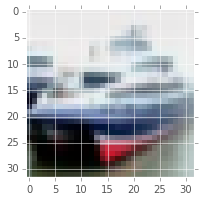

In [19]:
plt.figure(figsize=(3,3))
plt.imshow(imdeprocess(test_data[1]), interpolation='none')
print 'label: ' + label_names[test_labels[1]]
predict(test_data[1])